# Evaluation System for Classification of Sifar10 Data Set

In [1]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt

# tensorflow와 tf.keras를 임포트한다
import tensorflow as tf
from tensorflow import keras

# confusion matrix의 heatmap를 그리기 위해 seaborn module를 임포트
from sklearn.metrics import confusion_matrix
import seaborn as sns

from helper import ModelOptimizer

# class_labels의 사전(dictionary)을 참조하여 이미지의 부류 label를부여할 때 사용하십시요. 반드시  class_labels 사전(dictionary)의 키값의 순서를 따르기 바랍니다.

In [2]:
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_images_org, test_images_org = [], []
train_labels_org, test_labels_org = [], []

for label, class_name in enumerate(class_names):
    
    for i in range(0, 5000): # train set
        file = class_name + '/i0{0:04d}.jpg'.format(i+1) # 이미지 파일 이름을 만든다.
        image = imread('cifar10/' + file)                # 이미지를 읽는다.
        train_images_org.append(image)
        train_labels_org.append(label)
    
    for i in range(5000, 6000): # test set
        file = class_name + '/i0{0:04d}.jpg'.format(i+1) # 이미지 파일 이름을 만든다.
        image = imread('cifar10/' + file)                # 이미지를 읽는다.
        test_images_org.append(image)
        test_labels_org.append(label)

train_images_org = np.array(train_images_org)
test_images_org = np.array(test_images_org)

train_labels_org = np.array(train_labels_org)
test_labels_org = np.array(test_labels_org)

### shuffle input datas

In [4]:
import random

train_images, test_images = np.copy(train_images_org), np.copy(test_images_org)
train_labels, test_labels = np.copy(train_labels_org), np.copy(test_labels_org)

shuffle_index = [];
for i in range(50000):
    shuffle_index.append(i);
    
random.shuffle(shuffle_index);

for i in range(50000):
    train_images[i] = train_images[shuffle_index[i]];
    train_labels[i] = train_labels[shuffle_index[i]];
    
shuffle_index1 = [];
for i in range(10000):
    shuffle_index1.append(i);
    
random.shuffle(shuffle_index1);

for i in range(10000):
    test_images[i] = test_images[shuffle_index1[i]];
    test_labels[i] = test_labels[shuffle_index1[i]];
    
# x_train, x_test = np.array(train_images), np.array(test_images)
# y_train, y_test = np.array(train_labels), np.array(test_labels)
x_train, x_test = np.array(train_images), np.array(test_images)
y_train, y_test = np.array(train_labels), np.array(test_labels)

# 팀별로 자제 설계한 인공신경망 모델의 SavedModel 파일들은 반드시 jupyter notebook의 폴더 내에 ''./cifar10/savedModel/'에 위치해야한다.

### load model

In [5]:
model_dir = './cifar10/savedModel/'

model = tf.keras.models.load_model(model_dir)

In [6]:
BATCH_SIZE = 32
PRECISION = 'FP32'

print('Starting', 'CIFAR10', model_dir)
model_opt = ModelOptimizer(model_dir)

#save TensorRT engin at my_model_FP32 folder
opt_model = model_opt.convert(model_dir+'_'+PRECISION, precision=PRECISION)

print('Finished!\n')

Starting CIFAR10 ./cifar10/savedModel/
INFO:tensorflow:Linked TensorRT version: (8, 0, 1)
INFO:tensorflow:Loaded TensorRT version: (8, 0, 1)
INFO:tensorflow:Could not find TRTEngineOp_0_0 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Assets written to: ./cifar10/savedModel/_FP32/assets
Finished!



In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_images = train_images.astype('float32')
train_images /= 255

test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images = test_images.astype('float32')
test_images /= 255

# 성능 비교(수행시간, Confusion Matrix & Accuracy 성능) 
### - 10,000장의 test image는 test_images 배열(10000x32x32x3), test label 목적값은 test_label 배열(10000x1)에 저장되어 있어야 한다.
### - 따라서, 학습시킬 시에 각각 부류 이미지 마다 5001~6000 번호를 갖는 이미지들을 학습에 사용할 수 없으면 성능평가를 위한 test 이미지로 활용된다.
### - 팀별로 최종 프로젝트 프로그램 code를 보고서와 함께 제출해야 하며, 팀별로 설계한 인공신경망 모델과 trainning 이미지를 이용하여 다시 학습시켜 성능을 평가할 계획이다. 
### - 발표 시 후 성능평가와 이후 성능평가 결과가 다를 시에 팀 프로젝트 평가 점수에 불이익을 줄 계획이다. 반드시, 학습 시에 train_images 행렬을 사용하고 성능평가 시에 test_images를 사용하십시오.


### Performance Comparisons: Time

In [16]:
%%time
_ = model.predict(test_images)

CPU times: user 3.63 s, sys: 340 ms, total: 3.97 s
Wall time: 3.69 s


In [17]:
%%time
test_results = np.argmax(opt_model.predict(test_images), axis=1)

CPU times: user 148 ms, sys: 88 ms, total: 236 ms
Wall time: 1.09 s


### Performance Comparisons: Confusion Matrix and Accuracy

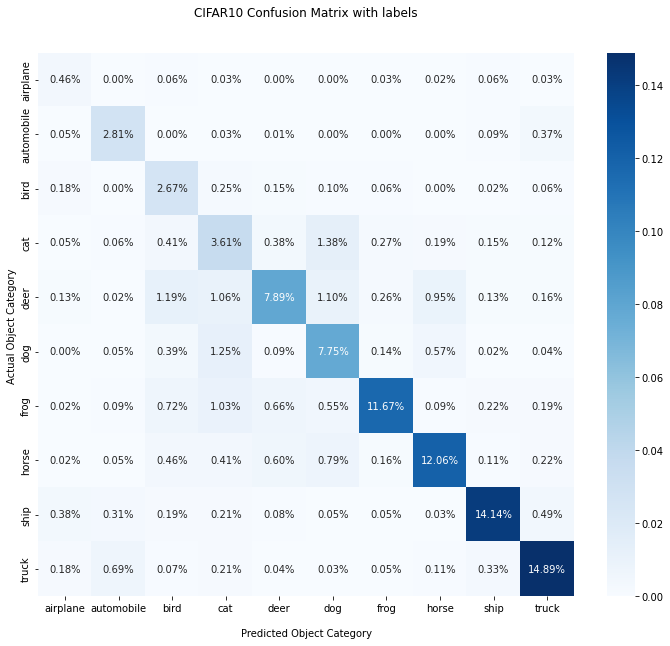


Accuracy: 0.779500



In [10]:
cf_matrix = confusion_matrix(test_results, test_labels)

plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%',cmap='Blues')

ax.set_title('CIFAR10 Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Object Category')
ax.set_ylabel('Actual Object Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels.values())
ax.yaxis.set_ticklabels(class_labels.values())

## Display the visualization of the Confusion Matrix.
plt.show()

accuracy = np.trace(cf_matrix)/len(test_labels)
print('\nAccuracy: {:.6f}\n'.format(accuracy))

# 이미지 비교

### images plot function

In [11]:
def plot_images(images, labels, preds, images_per_row=5):
    n_images = len(images)
    n_rows = (n_images-1) // images_per_row + 1
    fig, ax = plt.subplots(n_rows, images_per_row, 
                         figsize = (images_per_row * 2, n_rows * 2))
    for i in range(n_rows):
        for j in range(images_per_row):
            if i*images_per_row + j >= n_images: break
            img_idx = i*images_per_row + j
            a_image = images[img_idx].reshape(32,32,3)
            if n_rows>1:  axis = ax[i, j]
            else:         axis = ax[j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            label = '{0} | {1}'.format(class_names[labels[img_idx]],class_names[preds[img_idx]])
 
            axis.set_title(label)
            axis.imshow(a_image, interpolation='nearest')

### trainning images

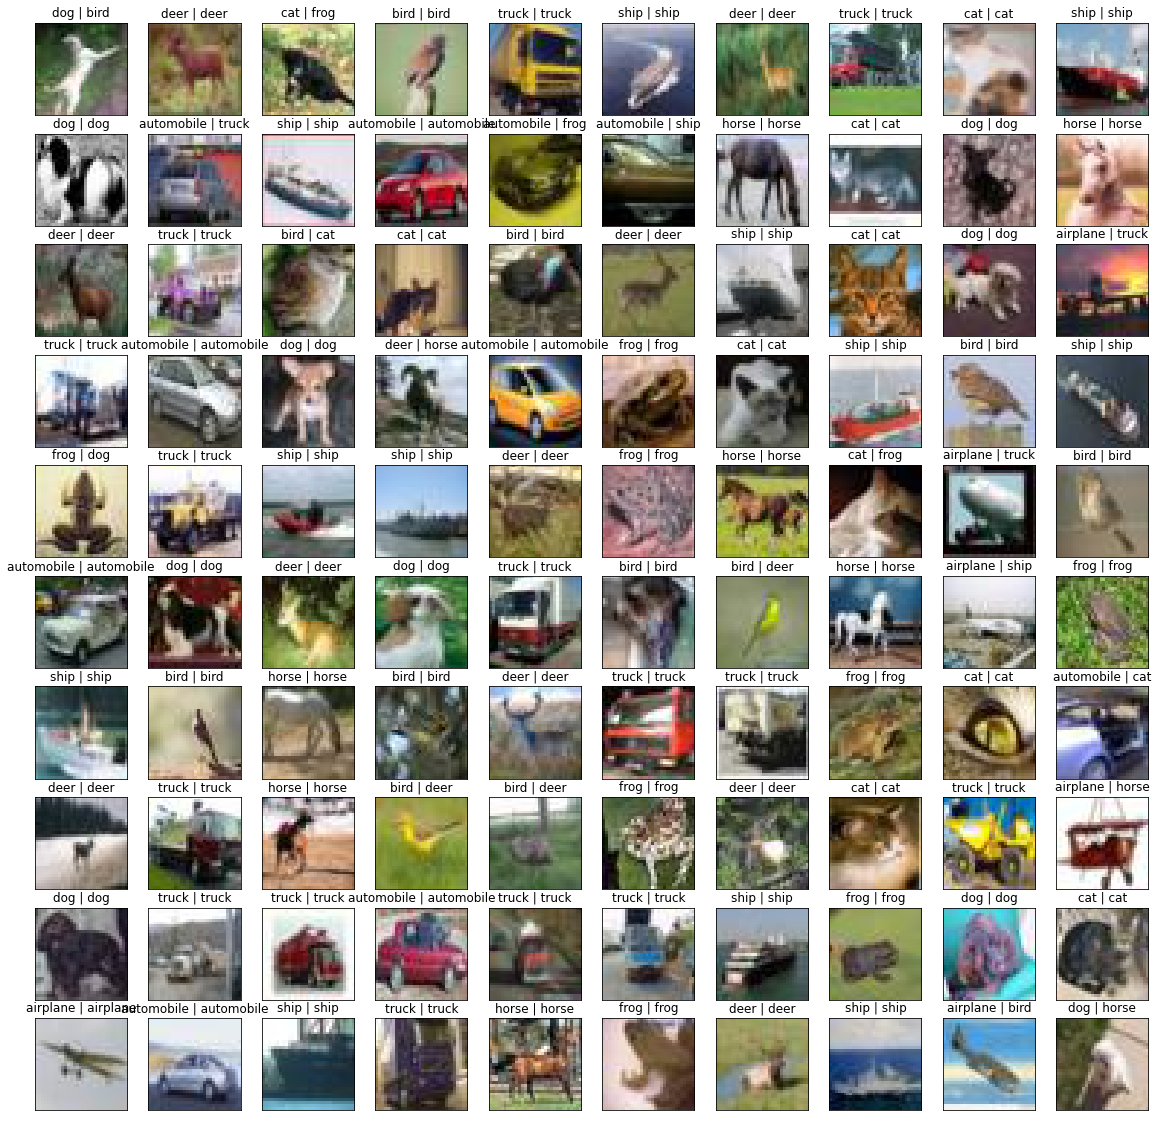

In [12]:
preds_train = np.argmax(opt_model.predict(train_images[:100]), axis=1)
plot_images(train_images[:100], train_labels[:100], preds_train, images_per_row=10)

### test images

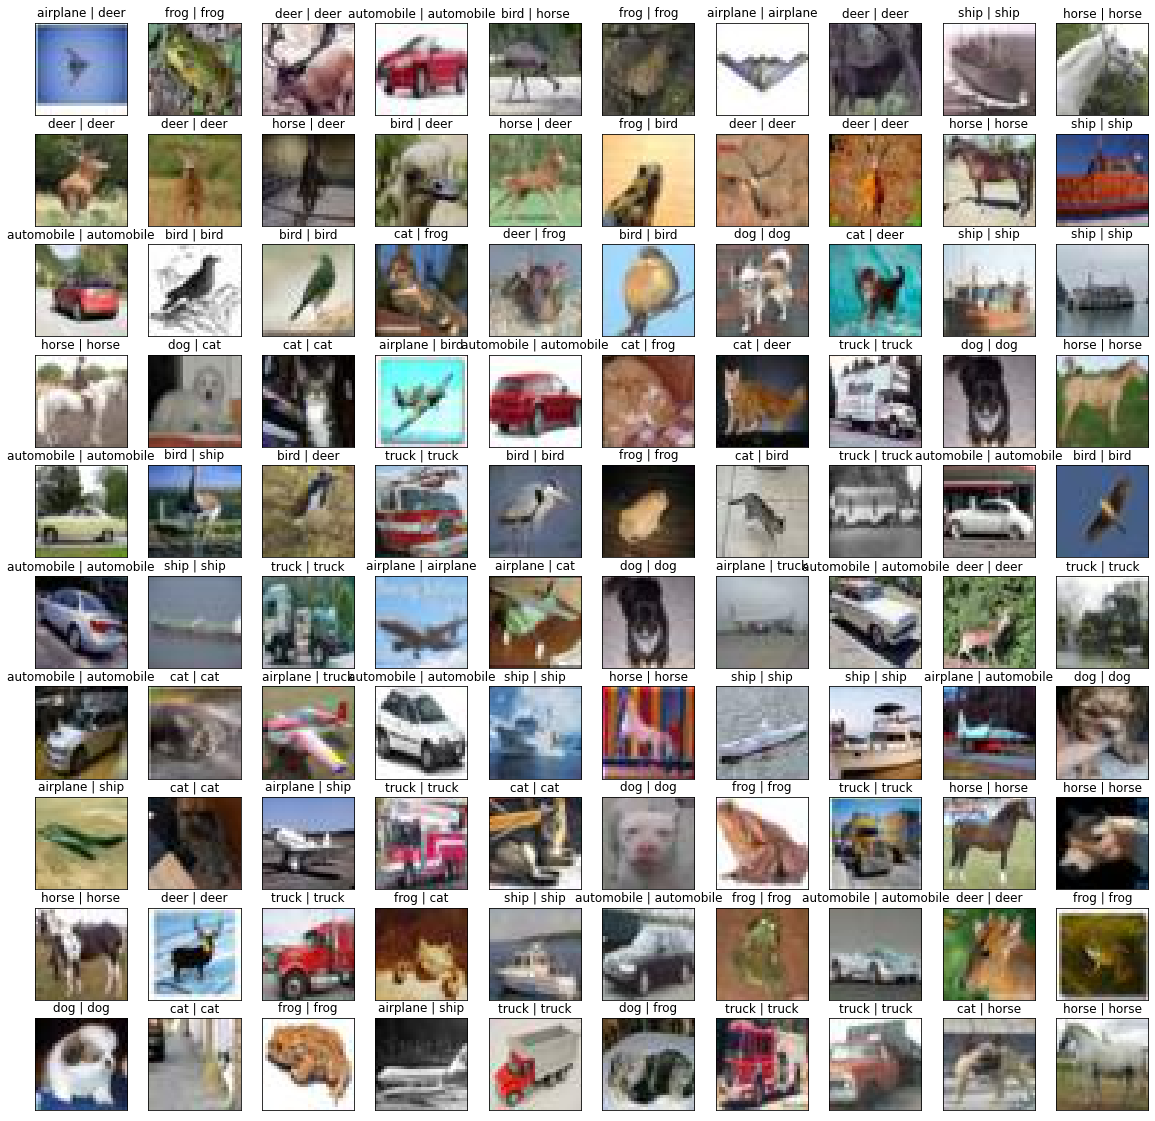

In [13]:
# preds_test = np.argmax(opt_model.predict(test_images[:100]), axis=1)
# plot_images(test_images[:100], test_labels[:100], preds_test, images_per_row=10)
preds_test = np.argmax(opt_model.predict(test_images[200:300]), axis=1)
plot_images(test_images[200:300], test_labels[200:300], preds_test, images_per_row=10)

### counting wrong classification

In [14]:
cnt = 0
for idx, pred_train in enumerate(preds_train):
    if not np.equal(pred_train, train_labels[idx]):
        cnt += 1
print('total wrong: ', cnt)

total wrong:  19


In [15]:
cnt = 0
for idx, pred_test in enumerate(preds_test):
    if not np.equal(pred_test, test_labels[idx+200]):
        cnt += 1
print('total wrong: ', cnt)

total wrong:  26
